In [102]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as mplani
from functools import partial

from pycocotools.coco import COCO
import glob
import json
from torchvision.ops import box_iou
import torch
from detectron2.structures import BoxMode
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict
from pprint import pprint
from scipy.signal import medfilt
import os
import copy
from PIL import Image
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
gt_path = "../data/val_annot_pos_neg_strict_frame_cocofied_vc.json"
gt_coco = COCO(gt_path)

loading annotations into memory...
Done (t=1.75s)
creating index...
index created!


In [78]:
print(set([os.path.dirname(img['file_name']) for img in gt_coco.loadImgs(duid2iids_ordered["val_0000000001"])]))

{'d5935c29-1b8d-417d-9bbb-5ebd47e9256d'}


In [79]:
print(set([os.path.dirname(img['file_name']) for img in gt_coco.loadImgs(duid2iids_ordered["val_0000000005"])]))

{'dfe962ab-6aa7-4888-9378-796817a30ab6'}


In [3]:
dt_paths = sorted(glob.glob("/scratch/shared/beegfs/prannay/ego4d_data/ckpt/perframe_run/inference_vq2d_val_pos_neg_strict_frame_vc/coco*.json"))
dt_paths

['/scratch/shared/beegfs/prannay/ego4d_data/ckpt/perframe_run/inference_vq2d_val_pos_neg_strict_frame_vc/coco_instances_results_0000000_0000002.json',
 '/scratch/shared/beegfs/prannay/ego4d_data/ckpt/perframe_run/inference_vq2d_val_pos_neg_strict_frame_vc/coco_instances_results_0000001_0000002.json']

In [4]:
detections = []
for dt_path in dt_paths:
    with open(dt_path, "r") as fp:
        detections += json.load(fp)

In [5]:
dt_coco = gt_coco.loadRes(detections)

Loading and preparing results...
DONE (t=49.05s)
creating index...
index created!


In [6]:
duids = set([gt_coco.imgs[iid]["dataset_uid"] for iid in gt_coco.imgs])
duid2iids = defaultdict(set)
for iid in gt_coco.imgs:
    duid = gt_coco.imgs[iid]["dataset_uid"]
    duid2iids[duid].add(iid)

In [7]:
# get iids for each duid in frame order
duid2iids_ordered = {}
for duid in duids:
    iids = duid2iids[duid]
    imgs = gt_coco.loadImgs(iids)
    iids = [img['id'] for img in sorted(imgs, key=lambda x: int(os.path.basename(x["file_name"]).split("_")[1].split(".")[0]))]
    duid2iids_ordered[duid] = iids

In [8]:
pprint([dt_coco.loadImgs(a)[0]['file_name'] for a in duid2iids_ordered[duid]])

['17e7a80c-b5ca-435f-a29e-0d026fcf2e96/frame_0000031.png',
 '17e7a80c-b5ca-435f-a29e-0d026fcf2e96/frame_0000032.png',
 '17e7a80c-b5ca-435f-a29e-0d026fcf2e96/frame_0000033.png',
 '17e7a80c-b5ca-435f-a29e-0d026fcf2e96/frame_0000034.png',
 '17e7a80c-b5ca-435f-a29e-0d026fcf2e96/frame_0000035.png',
 '17e7a80c-b5ca-435f-a29e-0d026fcf2e96/frame_0000036.png',
 '17e7a80c-b5ca-435f-a29e-0d026fcf2e96/frame_0000037.png',
 '17e7a80c-b5ca-435f-a29e-0d026fcf2e96/frame_0000038.png',
 '17e7a80c-b5ca-435f-a29e-0d026fcf2e96/frame_0000039.png',
 '17e7a80c-b5ca-435f-a29e-0d026fcf2e96/frame_0000040.png']


In [9]:
# get the max score and ann_id for each frame from duid2iids_ordered
duid2highest = defaultdict(list)
for duid, iids in tqdm(duid2iids_ordered.items(), total=len(duid2iids_ordered)):
    # print(iids)
    for iid in iids:
        dt_ann_ids = dt_coco.getAnnIds(imgIds=iid)
        dt_anns = dt_coco.loadAnns(dt_ann_ids)
        assert len(dt_anns)
        gt_ann_ids = gt_coco.getAnnIds(imgIds=iid)
        pos_frame = len(gt_ann_ids) > 0
        dt_anns = sorted(dt_anns, key=lambda x: x['score'], reverse=True)
        top_ann = copy.deepcopy(dt_anns[0])
        top_ann['positive'] = pos_frame
        # check iou with gt if pos_frame
        if pos_frame:
            gt_ann = gt_coco.loadAnns(gt_ann_ids)[0]
            bbox_gt = gt_ann['bbox']
            bbox_gt = BoxMode.convert(bbox_gt, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            bbox_dt = top_ann['bbox']
            bbox_dt = BoxMode.convert(bbox_dt, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            iou = box_iou(torch.tensor([bbox_gt]), torch.tensor([bbox_dt]))[0][0].item()
            top_ann['iou'] = iou
        else:
            top_ann['iou'] = -1.0
        duid2highest[duid].append(top_ann)

  0%|          | 0/4504 [00:00<?, ?it/s]

In [105]:
def get_medfilt_scores(duid2highest, gt_coco, duid):
    scores = [a['score'] for a in duid2highest[duid]]
    file_names = [gt_coco.loadImgs(a)[0]['file_name'] for a in duid2iids_ordered[duid]]
    fnos = [int(os.path.basename(fn).split("_")[1].split(".")[0]) for fn in file_names]
    scores_med = medfilt(scores, kernel_size=5).tolist()
    gt = [a['positive'] for a in duid2highest[duid]]
    ious = [a['iou'] for a in duid2highest[duid]]
    return fnos, scores_med, scores, gt, ious

In [106]:
fnos = []
scores_med = []
scores = []
gts = []
ious = []
for duid in tqdm(sorted(duids), total=len(duids)):
    fno, score_med, score_med, gt, iou = get_medfilt_scores(duid2highest, gt_coco, duid)
    fnos.append(np.array(fno))
    scores_med.append(np.array(score_med))
    scores.append(np.array(score_med))
    gts.append(np.array(gt))
    ious.append(iou)

  0%|          | 0/4504 [00:00<?, ?it/s]

In [107]:
# lets save the scores, median scores, fnos, gt
save_data = {
    "fnos": fnos,
    "scores": scores,
    "scores_med": scores_med,
    "gts": gts,
    "duids": sorted(duids),
    "ious": ious,
}
with open("/scratch/shared/beegfs/prannay/ego4d_data/ckpt/perframe_run/inference_vq2d_val_pos_neg_strict_frame_vc/duid2scores.pkl", "wb") as fp:
    pickle.dump(save_data, fp)

In [13]:
def plot_score_trace(duid2highest, gt_coco, duid, iou_thresh=0.5):
    file_names = [gt_coco.loadImgs(a)[0]['file_name'] for a in duid2iids_ordered[duid]]
    fnos = [int(os.path.basename(a).split("_")[1].split(".")[0]) for a in file_names]
    scores = [a['score'] for a in duid2highest[duid]]
    scores_med = medfilt(scores, kernel_size=5).tolist()
    # print(scores)
    pos = [a['positive'] for a in duid2highest[duid]]
    correct = [a['iou'] > iou_thresh for a in duid2highest[duid]]
    scores_true_pos = [sc for sc, p, c in zip(scores, pos, correct) if p and c]
    scores_missed_pos = [sc for sc, p, c in zip(scores, pos, correct) if p and not c]
    scores_negative = [sc for sc, p, c in zip(scores, pos, correct) if not p]

    scores_med_true_pos = [sc for sc, p, c in zip(scores_med, pos, correct) if p and c]
    scores_med_missed_pos = [sc for sc, p, c in zip(scores_med, pos, correct) if p and not c]
    scores_med_negative = [sc for sc, p, c in zip(scores_med, pos, correct) if not p]

    fnos_true_pos = [fno for fno, p, c in zip(fnos, pos, correct) if p and c]
    fnos_missed_pos = [fno for fno, p, c in zip(fnos, pos, correct) if p and not c]
    fnos_negative = [fno for fno, p, c in zip(fnos, pos, correct) if not p]
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    ax[0].plot(fnos, scores, c="k")
    ax[0].plot(fnos_true_pos, scores_true_pos, c="y", marker="o", ls="None", ms=10)
    ax[0].plot(fnos_missed_pos, scores_missed_pos, c="b", marker="o", ls="None", ms=10)
    ax[0].plot(fnos_negative, scores_negative, c="b", marker="x", ls="None", ms=10)

    ax[1].plot(fnos, scores_med, c="k")
    ax[1].plot(fnos_true_pos, scores_med_true_pos, c="y", marker="o", ls="None", ms=10)
    ax[1].plot(fnos_missed_pos, scores_med_missed_pos, c="b", marker="o", ls="None", ms=10)
    ax[1].plot(fnos_negative, scores_med_negative, c="b", marker="x", ls="None", ms=10)

    # save the plot
    # med_tog = "med" if med_filt else "raw"
    file_name = f"score_trace_{duid}.pdf"
    directory = "/scratch/shared/beegfs/prannay/ego4d_data/ckpt/perframe_run/inference_vq2d_val_pos_neg_strict_frame_vc/traces/"
    plt.tight_layout()
    # plt.savefig(os.path.join(directory, file_name))
    plt.show()

  0%|          | 0/4504 [00:00<?, ?it/s]

val_0000000005


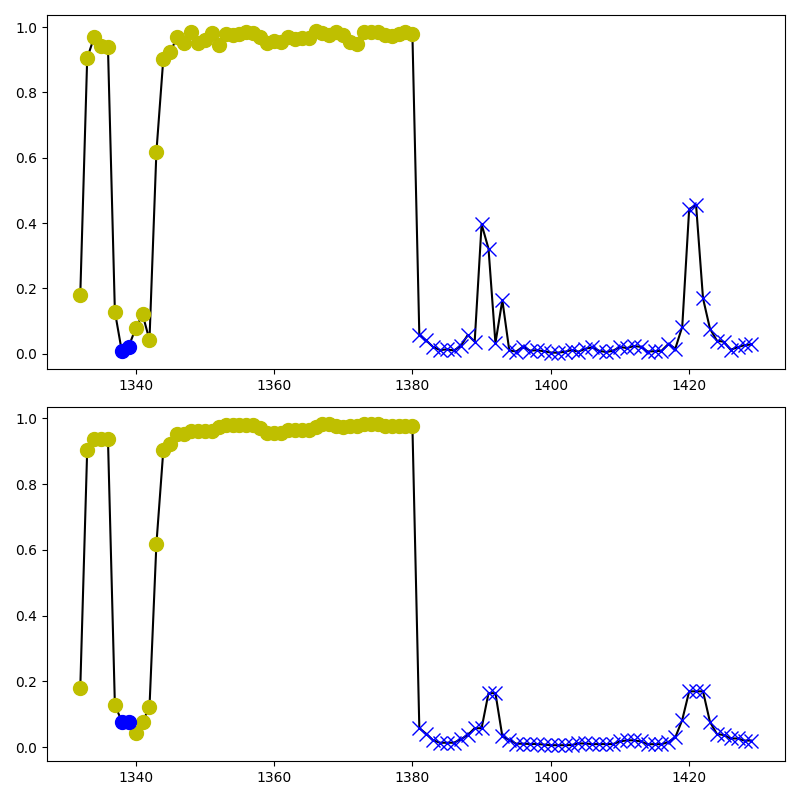

In [14]:
run_save = True
if run_save:
    import warnings
    warnings.filterwarnings("ignore")
    for duid in tqdm(sorted(sorted(duids)[5:6]), total=len(duids)):
        print(duid)
        plot_score_trace(duid2highest, gt_coco, duid, iou_thresh=0.3)
    warnings.filterwarnings("default")

In [15]:
duid2highest["val_0000000005"][:3]

[{'image_id': 318,
  'category_id': 1,
  'bbox': [1.639207363128662,
   1052.9156494140625,
   99.1135482788086,
   27.0843505859375],
  'score': 0.18051107227802277,
  'segmentation': [[1.639207363128662,
    1052.9156494140625,
    1.639207363128662,
    1080.0,
    100.75275564193726,
    1080.0,
    100.75275564193726,
    1052.9156494140625]],
  'area': 2684.4260893994942,
  'id': 8599809,
  'iscrowd': 0,
  'positive': True,
  'iou': 0.6692595481872559},
 {'image_id': 319,
  'category_id': 1,
  'bbox': [6.519870758056641,
   1008.3377075195312,
   82.25833129882812,
   67.38067626953125],
  'score': 0.9050368070602417,
  'segmentation': [[6.519870758056641,
    1008.3377075195312,
    6.519870758056641,
    1075.7183837890625,
    88.77820205688477,
    1075.7183837890625,
    88.77820205688477,
    1008.3377075195312]],
  'area': 5542.621991718188,
  'id': 20353,
  'iscrowd': 0,
  'positive': True,
  'iou': 0.7571434378623962},
 {'image_id': 320,
  'category_id': 1,
  'bbox': [1.

In [92]:
def plot_frame(frame, ax=None):
    image = Image.open(frame['file_name'])
    fno = int(os.path.basename(frame['file_name']).split("_")[1].split(".")[0])
    bbox = frame['bbox']
    score = frame['score']
    positive = frame['positive']
    correct = frame['iou'] > 0.5

    box_colour = "g" if positive and correct else "y" if positive and not correct else "r"

    # fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    ax[1].clear()
    ax[1].imshow(image)
    ax[1].add_patch(Rectangle((bbox[0]-5, bbox[1]-5), bbox[2]+5, bbox[3]+5, fill=False, edgecolor=box_colour, linewidth=10))
    ax[1].set_title(f"Frame: {fno}, Score: {score:4.2f}, Positive: {positive}, Correct: {correct}")
    ax[1].set_axis_off()
    
    plot_colour = "y" if correct else "b"
    plot_marker = "o" if positive else "x"
    ax[0].plot(fno, score, c=plot_colour, marker=plot_marker, ls="None", ms=10)
    ax[0].set_xlim([frame['start_frame']-2, frame['end_frame']+2])
    ax[0].set_ylim([0.0, 1.0])
    return ax

def create_frames_from_duid(duid, gt_coco, duid2highest):
    frames = copy.deepcopy(duid2highest[duid])
    for frame in frames:
        frame['file_name'] = os.path.join(
            "/scratch/shared/beegfs/prannay/ego4d_data/images_val/",
            gt_coco.loadImgs(frame['image_id'])[0]['file_name'],
        )
        frame['frame_no'] = int(os.path.basename(frame['file_name']).split("_")[1].split(".")[0])
    for frame in frames:
        frame['start_frame'] = frames[0]['frame_no']
        frame['end_frame'] = frames[-1]['frame_no']
    return frames

In [73]:
duid_to_plot = "val_0000000001"
frames_to_plot = create_frames_from_duid(duid_to_plot, gt_coco, duid2highest)

In [74]:
with open("temp_frames.json", "w") as fp:
    json.dump(frames_to_plot, fp)

In [75]:
with open("temp_frames.json", "r") as fp:
    frames_to_plot = json.load(fp)

In [38]:
# plt.close("all")
# # plt.tight_layout()
# fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [1, 3]})
# plot_frame(frames_to_plot[0])

In [46]:
import time
t = time.time()
fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 3]})
ax[1].set_axis_off()
animation = FuncAnimation(fig, plot_frame, frames=frames_to_plot, interval=200)
plt.tight_layout()
animation.save('basic_animation.gif', fps=2, writer='imagemagick', dpi=128)
plt.close()
print(time.time() - t)

/users/prannay/miniconda3/envs/vq2d/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:501: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


72.64735102653503


In [87]:
t = time.time()
fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 3]})
ax[1].set_axis_off()
animation = FuncAnimation(fig, plot_frame, frames=frames_to_plot, interval=200)
plt.tight_layout()
ani_writer = mplani.PillowWriter(fps=2, metadata={"dpi": 256}, bitrate=720)
animation.save(f"/scratch/shared/beegfs/prannay/ego4d_data/ckpt/perframe_run/inference_vq2d_val_pos_neg_strict_frame_vc/gifs/{duid_to_plot}.gif", writer=ani_writer)
plt.close()
print(time.time() - t)

/users/prannay/miniconda3/envs/vq2d/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:501: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


14.784685134887695


In [89]:
from multiprocessing import Pool
from functools import partial

In [96]:
def f(duid):
    frames = create_frames_from_duid(duid, gt_coco, duid2highest)
    # print(len(frames))
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 3]})
    ax[1].set_axis_off()
    anim = FuncAnimation(fig, partial(plot_frame, ax=ax), frames=frames, interval=500)
    # plt.tight_layout()
    ani_writer = mplani.PillowWriter(fps=2, metadata={"dpi": 256}, bitrate=720)
    file_name = f"/scratch/shared/beegfs/prannay/ego4d_data/ckpt/perframe_run/inference_vq2d_val_pos_neg_strict_frame_vc/gifs/{duid}.gif"
    anim.save(file_name, writer=ani_writer)
    plt.close()
    return duid

In [97]:
f(sorted(duids)[1])

/users/prannay/miniconda3/envs/vq2d/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:501: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


'val_0000000001'

In [98]:
# for duid in tqdm(sorted(duids), total=len(duids)):
#     frames_to_plot = create_frames_from_duid(duid_to_plot, gt_coco, duid2highest)
#     fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 3]})
#     ax[1].set_axis_off()
#     animation = FuncAnimation(fig, plot_frame, frames=frames_to_plot, interval=200)
#     plt.tight_layout()
#     ani_writer = mplani.PillowWriter(fps=2, metadata={"dpi": 256}, bitrate=720)
#     file_name = f"/scratch/shared/beegfs/prannay/ego4d_data/ckpt/perframe_run/inference_vq2d_val_pos_neg_strict_frame_vc/gifs/{duid}.gif"
#     animation.save(file_name, writer=ani_writer)
#     plt.close()

In [103]:
plt.close("all")

In [104]:
with Pool(24) as p:
    _ = list(p.imap(f, tqdm(sorted(duids))))

  0%|          | 0/4504 [00:00<?, ?it/s]